*This notebook contains implementation and training of custom model. Here genetic algorithm is not used for hyperparameter tuning.*

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import torch
from imblearn.over_sampling import SMOTE
from torch.utils.data import DataLoader, TensorDataset

# Load data
data = pd.read_csv('transaction_dataset.csv')  # Update the path accordingly

data = data.dropna()

# Assuming 'features' are the input features and 'label' is the target variable
X = data.drop('FLAG', axis=1)  # Update 'FLAG' to your target column name if different
y = data['FLAG']  # Update 'FLAG' to your target column name if different

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(exclude=['object']).columns.tolist()

# Preprocess the data
preprocessor = ColumnTransformer(
    transformers=[('num', StandardScaler(), numerical_cols),
                  ('cat', OneHotEncoder(), categorical_cols)])

X = preprocessor.fit_transform(X)

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split the data into training, testing, and validation sets
X_train, X_temp, y_train, y_temp = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train.toarray(), dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.long)
X_val = torch.tensor(X_val.toarray(), dtype=torch.float32)
y_val = torch.tensor(y_val.values, dtype=torch.long)
X_test = torch.tensor(X_test.toarray(), dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.long)

# Create data loaders
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [2]:
import torch.nn as nn
import torch.nn.functional as F

class DeepResidualANNModel(nn.Module):
    def __init__(self):
        super(DeepResidualANNModel, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 128)  # Layer for residual connection
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 64)    # Layer for residual connection
        self.fc6 = nn.Linear(64, 64)
        self.fc_out = nn.Linear(64, 2)  # Assuming binary classification

    def forward(self, x):
        x = F.relu(self.fc1(x))
        
        # First residual connection
        x_residual1 = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x_residual1)) + x_residual1  # Adding residual connection
        
        x = F.relu(self.fc4(x))
        
        # Second residual connection
        x_residual2 = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x_residual2)) + x_residual2  # Adding residual connection
        
        x = self.fc_out(x)
        return F.log_softmax(x, dim=1)

# Instantiate the model
model = DeepResidualANNModel()

Epoch 1/20, Training Loss: 0.0903, Test Accuracy: 0.9974
Epoch 2/20, Training Loss: 0.0066, Test Accuracy: 0.9965
Epoch 3/20, Training Loss: 0.1226, Test Accuracy: 0.9974
Epoch 4/20, Training Loss: 1.1763, Test Accuracy: 0.9965
Epoch 5/20, Training Loss: 0.0304, Test Accuracy: 0.9974
Epoch 6/20, Training Loss: 0.4518, Test Accuracy: 0.9870
Early stopping on epoch 6
Final Test Accuracy: 0.9974


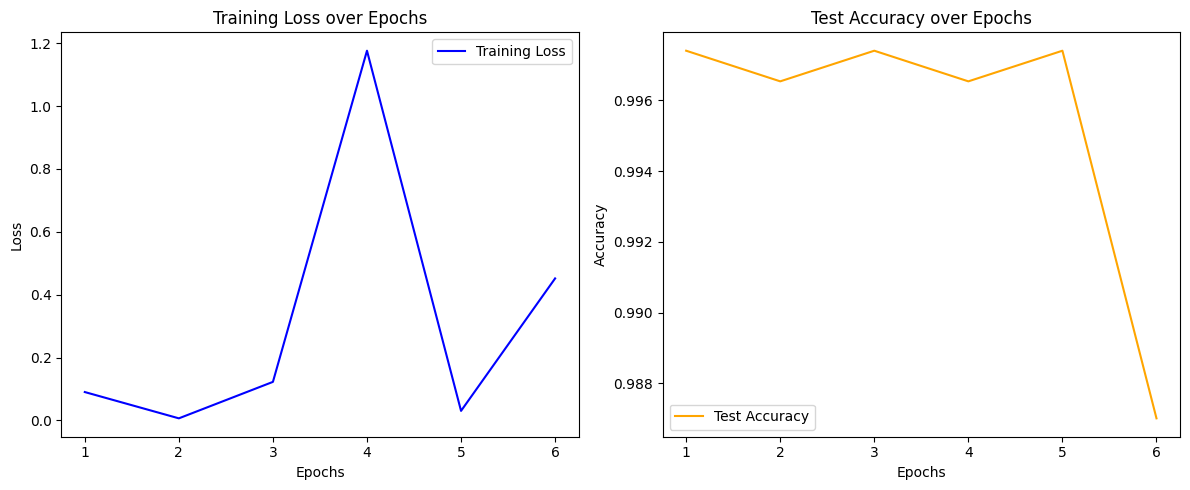

In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Define your model, data loaders, and optimizer here
# Assuming model, train_loader, test_loader, and device are already set up

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

train_losses = []
test_accuracies = []

patience = 5
best_accuracy = 0
epochs_no_improve = 0
num_epochs = 20 

for epoch in range(num_epochs):
    
    # Training phase
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to device if necessary
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = F.nll_loss(outputs, labels)  # Negative Log Likelihood Loss
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Evaluation phase
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to device if necessary
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    test_accuracies.append(accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Test Accuracy: {accuracy:.4f}")

    # Early stopping check
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f'Early stopping on epoch {epoch+1}')
        break

# Final Test Accuracy
print(f'Final Test Accuracy: {best_accuracy:.4f}')

# Plotting Training Loss and Test Accuracy
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 5))

# Plot Training Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

# Plot Test Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, test_accuracies, label='Test Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Test Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


In [4]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support

# Lists to store predictions and labels for computing F1 score, precision, and recall
all_predictions = []
all_labels = []

for inputs, labels in val_loader:
    outputs = model(inputs)
    _, predicted = torch.max(outputs.data, 1)
    all_predictions.extend(predicted.tolist())
    all_labels.extend(labels.tolist())

precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='weighted')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Precision: 0.9949
Recall: 0.9948
F1 Score: 0.9948
